<a href="https://colab.research.google.com/github/RealMyeong/NLP_kaggle_transcription/blob/main/Mercari_Price_Suggestion_Challenge_Transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data fields
### train.tsv, test.tsv

- train_id, test_id : the id of listing
- name : title of listing. 가격표시($20)같은 텍스트는 유출을 막기위해서 삭제하거나 정제해줬음. 삭제된 가격들은 [rm]으로 표시함
- item_condition_id : 판매자가 제공하는 제품의 상태
- category_name : category of the listing
- brand_name
- price : 우리가 예측해야할 target variable로 판매 가격임. 단위는 USD임. test.tsv에는 없음. 
- shipping : 배송비 판매자 부담이면 1, 구매자 부담이면 0
- item_description : 상품 설명. 

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import math

In [2]:
# 손실함수 정의
def rmsle(y, y_pred):
  assert len(y) == len(y_pred)
  to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
  return (sum(to_sum) * (1.0 / len(y))) ** 0.5
  

In [3]:
# 데이터 불러오기
print("Loading data...")
train = pd.read_table('/content/drive/MyDrive/AIFFEL/NLP_캐글필사/Mercari_Price/train.tsv')
test = pd.read_table('/content/drive/MyDrive/AIFFEL/NLP_캐글필사/Mercari_Price/test.tsv')
print(train.shape)
print(test.shape)

Loading data...
(1482535, 8)
(693359, 7)


In [4]:
# 결측치 처리
print('결측치 처리중...')

def handle_missing(dataset):
  dataset.category_name.fillna(value='missing', inplace=True)
  dataset.brand_name.fillna(value='missing', inplace=True)
  dataset.item_description.fillna(value='missing', inplace=True)
  return dataset

train = handle_missing(train)
test = handle_missing(test)
print(train.shape)
print(test.shape)

결측치 처리중...
(1482535, 8)
(693359, 7)


In [5]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity


In [6]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,missing,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,missing,1,Rediscovering life after the loss of a loved o...


In [7]:
# 범주형 데이터 처리
print('범주형 데이터 처리중...')
le = LabelEncoder()

le.fit(np.hstack([train.category_name, test.category_name]))
train.category_name = le.transform(train.category_name)
test.category_name = le.transform(test.category_name)

le.fit(np.hstack([train.brand_name, test.brand_name]))
train.brand_name = le.transform(train.brand_name)
test.brand_name = le.transform(test.brand_name)
del le

train.head()

범주형 데이터 처리중...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity


In [8]:
# 텍스트 전처리
print(' 텍스트를 Sequence로 바꾸는 중....')
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([train.item_description.str.lower(), train.name.str.lower()])

print(' Tokenizer 학습중...')
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)

train['seq_item_description'] = tok_raw.texts_to_sequences(train.item_description.str.lower())
test['seq_item_description'] = tok_raw.texts_to_sequences(test.item_description.str.lower())
train['seq_name'] = tok_raw.texts_to_sequences(train.name.str.lower())
test['seq_name'] = tok_raw.texts_to_sequences(test.name.str.lower())
train.head()

 텍스트를 Sequence로 바꾸는 중....
 Tokenizer 학습중...


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,seq_item_description,seq_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,829,5265,10.0,1,No description yet,"[12, 68, 79]","[3852, 8823, 6896, 208, 84, 6, 155]"
1,1,Razer BlackWidow Chroma Keyboard,3,86,3889,52.0,0,This keyboard is in great condition and works ...,"[29, 2627, 10, 7, 39, 17, 1, 207, 51, 19, 1113...","[10760, 25565, 16369, 2627]"
2,2,AVA-VIV Blouse,1,1277,4588,10.0,1,Adorable top with a hint of lace and a key hol...,"[604, 60, 9, 4, 5347, 11, 192, 1, 4, 886, 1290...","[7634, 10563, 666]"
3,3,Leather Horse Statues,1,503,5265,35.0,1,New with tags. Leather horses. Retail for [rm]...,"[5, 9, 61, 178, 6528, 230, 3, 21, 166, 1085, 2...","[178, 2610, 14248]"
4,4,24K GOLD plated rose,1,1204,5265,44.0,0,Complete with certificate of authenticity,"[807, 9, 6888, 11, 1997]","[4884, 104, 1032, 280]"


In [9]:
# sequence 변수 분석
max_name_seq = np.max([np.max(train.seq_name.apply(lambda x : len(x))), np.max(test.seq_name.apply(lambda x : len(x)))])
max_seq_item_description = np.max([np.max(train.seq_item_description.apply(lambda x : len(x))),
                                   np.max(test.seq_item_description.apply(lambda x : len(x)))])

print('max name seq ' + str(max_name_seq))
print('max item description seq ' + str(max_seq_item_description))

max name seq 17
max item description seq 269


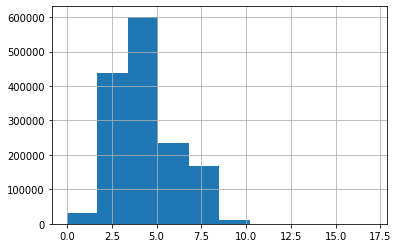

In [10]:
train.seq_name.apply(lambda x : len(x)).hist()

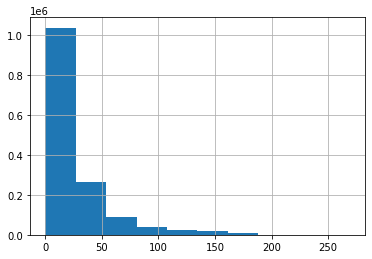

In [11]:
train.seq_item_description.apply(lambda x : len(x)).hist()

In [12]:
# embedding max value
# base on histograms, we select the next lengths
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(train.seq_name.max()),
                   np.max(test.seq_name.max()),
                   np.max(train.seq_item_description.max()),
                   np.max(test.seq_item_description.max())]) +2
MAX_CATEGORY = np.max([train.category_name.max(), test.category_name.max()]) +1
MAX_BRAND = np.max([train.brand_name.max(), test.brand_name.max()]) +1
MAX_CONDITION = np.max([train.item_condition_id.max(), test.item_condition_id.max()]) + 1

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09014b3f90>]],
      dtype=object)

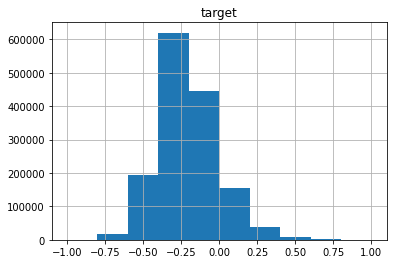

In [13]:
# scale target variables
train['target'] = np.log(train.price + 1)
target_scaler = MinMaxScaler(feature_range=(-1,1))
train['target'] = target_scaler.fit_transform(train.target.values.reshape(-1,1))
pd.DataFrame(train.target).hist()

In [14]:
# extra development test
dtrain, dvalid = train_test_split(train, random_state=123, train_size=0.99)
print(dtrain.shape)
print(dvalid.shape)

(1467709, 11)
(14826, 11)


In [16]:
# keras data definition
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
  X = {
      'name' : pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ),
       'item_desc' : pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ),
       'brand_name' : np.array(dataset.brand_name),
       'category_name' : np.array(dataset.category_name),
       'item_condition' : np.array(dataset.item_condition_id),
       'num_vars' : np.array(dataset[['shipping']])
  }
  return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

In [18]:
# keras model definition
import tensorflow
from tensorflow.keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import backend as K

def get_callbacks(filepath, patience=2):
  es = EarlyStopping('val_loss', patience=patience, mode='min')
  msave = ModelCheckpoint(filepath, save_best_only=True)
  return [es, msave]

def rmsle_cust(y_true, y_pred):
  first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
  second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
  return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
  dr_r = 0.1

  #Inputs
  name = Input(shape=[X_train['name'].shape[1]], name='name')
  item_desc = Input(shape=[X_train['item_desc'].shape[1]], name='item_desc')
  brand_name = Input(shape=[1], name='brand_name')
  category_name = Input(shape=[1], name='category_name')
  item_condition = Input(shape=[1], name='item_condition')
  num_vars = Input(shape=[X_train['num_vars'].shape[1]], name='num_vars')

  #Embeddings layers
  emb_name = Embedding(MAX_TEXT, 50)(name)
  emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
  emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
  emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
  emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)

  # rnn layer
  rnn_layer1 = GRU(16)(emb_item_desc)
  rnn_layer2 = GRU(8)(emb_name)

  # main layer
  main_1 = concatenate([
      Flatten()(emb_brand_name),
      Flatten()(emb_category_name),
      Flatten()(emb_item_condition),
      rnn_layer1,
      rnn_layer2,
      num_vars
  ])
  main_1 = Dropout(dr_r)(Dense(128)(main_1))
  main_1 = Dropout(dr_r)(Dense(64)(main_1))

  # output
  output = Dense(1, activation='linear')(main_1)

  # model
  model = Model([name, item_desc, brand_name, category_name, item_condition, num_vars], output)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', rmsle_cust])

  return model

model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 brand_name (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 category_name (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 item_condition (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 item_desc (InputLayer)         [(None, 75)]         0           []                               
                                                                                              

In [20]:
# fitting the model
BATCH_SIZE = 20000
epochs = 5

model = get_model()
model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_valid, dvalid.target),
          verbose=1)

Epoch 1/5
74/74 [==============================] - 242s 3s/step - loss: 0.0297 - mae: 0.1309 - rmsle_cust: 0.0156 - val_loss: 0.0186 - val_mae: 0.1033 - val_rmsle_cust: 0.0136
Epoch 2/5
74/74 [==============================] - 230s 3s/step - loss: 0.0186 - mae: 0.1035 - rmsle_cust: 0.0134 - val_loss: 0.0164 - val_mae: 0.0973 - val_rmsle_cust: 0.0128
Epoch 3/5
74/74 [==============================] - 234s 3s/step - loss: 0.0163 - mae: 0.0967 - rmsle_cust: 0.0126 - val_loss: 0.0155 - val_mae: 0.0948 - val_rmsle_cust: 0.0125
Epoch 4/5
74/74 [==============================] - 235s 3s/step - loss: 0.0150 - mae: 0.0928 - rmsle_cust: 0.0122 - val_loss: 0.0155 - val_mae: 0.0948 - val_rmsle_cust: 0.0125
Epoch 5/5
74/74 [==============================] - 232s 3s/step - loss: 0.0143 - mae: 0.0902 - rmsle_cust: 0.0119 - val_loss: 0.0154 - val_mae: 0.0944 - val_rmsle_cust: 0.0124


In [22]:
# Evaluate the model on dev test : what is it doing?
val_preds = model.predict(X_valid)
val_preds = target_scaler.inverse_transform(val_preds)
val_preds = np.exp(val_preds) + 1

# mean_absolute_error, mead_squared_log_error
y_true = np.array(dvalid.price.values)
y_pred = val_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print('RMSLE error on dev test: '+str(v_rmsle))

464/464 [==============================] - 5s 10ms/step
RMSLE error on dev test: 0.4922721028338256
